## Assignment 8
The goal of this lab is to examine and experiment with several techniques related to influence analysis
in complex networks. Influence is defined between two users and represents how
possible is for a user to adapt the behavior or copy the action of another user. 

We will first introduce the diffusion model which can be used to simulate a spreading process that takes place over the network.
 
Subsequently, we will utilize the structure of the network to identify influencers based in a heuristic manner.

Finally, we will examine the algorithmic solution to the problem of influence maximization,
which is choosing the optimum nodes to maximize the spread of information, and compare it with
the heuristic approach based on the simulations.

We will again rely on the network sciecne dataset for our use case. The following questions can be answered with the help of networkx and NDlib. You may also use other packages to deal with the problem. Please answer the following questions on the networks you have and submit your executable code.

In [14]:
import networkx as nx
from ndlib.models.epidemics import IndependentCascadesModel
from ndlib.models.ModelConfig import Configuration
from matplotlib import pyplot as plt
import rich

In [7]:
path = ""

In [8]:
# download a file from a url 
import requests

def download(url,file_name):
    get_response = requests.get(url)
    with open(file_name, "wb") as out_file:
        out_file.write(get_response.content)

download(url = "http://www.casos.cs.cmu.edu/computational_tools/datasets/external/netscience/netscience.gml", file_name=path+"netscience.gml")

The graph has 1589 nodes and 2742 edges


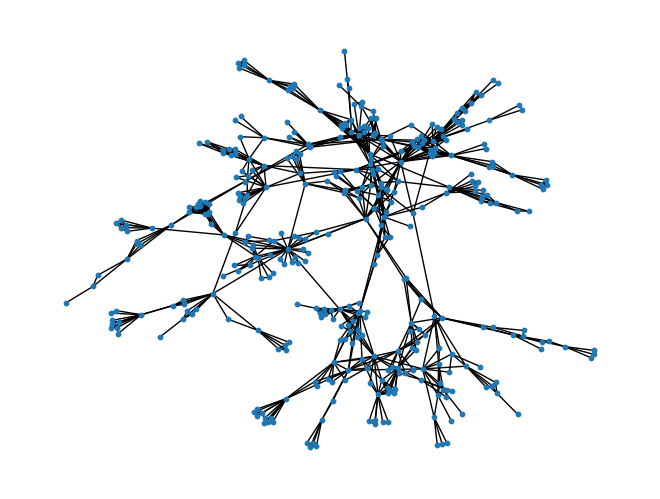

In [9]:
# Read the data and show the basic information
graph = nx.read_gml(path+"netscience.gml")
print(f"The graph has {len(graph.nodes)} nodes and {len(graph.edges)} edges")

sub_graph = graph.subgraph(max(nx.connected_components(graph), key=len))
pos = nx.spring_layout(sub_graph)
nx.draw(sub_graph, pos, with_labels=False, edge_color='black', node_size=10)
plt.show()

**(a)** We will first create a method to evaluate our chosen seeds, based on epidemic simulation. As a means for evaluation, we use the Independent Cascade model, to compute the number of influenced nodes during an influence spread over the network. 
This model assumes that a node v has only one chance to influence each of its neighbors u based on the probability `p v,u` . 
We define the model's parameters (threshold=0.01) based on common approaches in the literature, and run the epidemic through 10 steps in order to get an approximation and retreive fast results (in normal circumstances it is 10 thousand).


In terms of implementation we will define a function $simulate\_spreading$ that performs the simulation using the IndependentCascadeModel and ModelConfig from NDlib.
More specficially, we have to loop through the edges and add a variable named "threshold" that resembles the probability of influencing a node's neighbors (set to $0.01$ as is common in the literature for dense graphs), using the function $add\_edge\_configuration$.


In [12]:


def simulate_spreading(G,seed_set,sim=10,num_steps=5,threshold = 0.01):
    """
    Given the graph and the seed set, compute the number of infected nodes after the end of a spreading process
    """
    model = IndependentCascadesModel(G)
    config = Configuration()
    config.add_model_initial_configuration("Infected", seed_set)
    for edge in G.edges():
        config.add_edge_configuration("threshold", edge, threshold)
    
    model.set_initial_status(config)
    iterations = model.iteration_bunch(num_steps)
    
    return iterations


simulate_spreading(graph, [0,1,2,3,4,5,6,7,8,9], num_steps=5, threshold=0.01)[-1]

{'iteration': 4,
 'status': {},
 'node_count': {0: 1589, 1: 10, 2: 0},
 'status_delta': {0: 0, 1: 0, 2: 0}}

**(b)** Compute K-core score:  Given our undirected network G, C k is defined as the k-core subgraph of G if it is a maximal connected subgraph in which all nodes have degree at least k. Then, each node v ∈ V has a core number c(v) = k, if it belongs to a k-core but not to a (k + 1)-core. The cohesion of subgraphs increases as k increases. Let us denote as C the set of nodes with the maximum core number k\_max. Compute the top 20 nodes in terms of the k-core they belong to and simulate their spreading.

In [15]:
import networkx as nx

def compute_k_core_and_simulate(graph, top_n=20, threshold=0.01, steps=10):
    """
    Computes the K-core scores and simulates spreading for the top nodes.

    Parameters:
    - graph: A NetworkX graph representing the network.
    - top_n: Number of top nodes based on core number (default=20).
    - threshold: Influence probability for edges (default=0.01).
    - steps: Number of simulation steps to run (default=10).

    Returns:
    - top_nodes: List of top nodes and their core numbers.
    - spreading_results: Results of the spreading simulation.
    """
    core_numbers = nx.core_number(graph)
    sorted_nodes = sorted(core_numbers.items(), key=lambda x: x[1], reverse=True)
    top_nodes = sorted_nodes[:top_n]
    top_node_ids = [node for node, _ in top_nodes]
    spreading_results = simulate_spreading(graph, top_node_ids, threshold, steps)

    return top_nodes, spreading_results


top_nodes, spreading_results = compute_k_core_and_simulate(graph, top_n=(top_n:=20), threshold=0.01, steps=10)

print(*[f"Node {node} has core number {core}" for node, core in top_nodes], sep="\n")

Node GIOT, L has core number 19
Node UETZ, P has core number 19
Node CAGNEY, G has core number 19
Node MANSFIELD, T has core number 19
Node JUDSON, R has core number 19
Node KNIGHT, J has core number 19
Node LOCKSHON, D has core number 19
Node NARAYAN, V has core number 19
Node SRINIVASAN, M has core number 19
Node POCHART, P has core number 19
Node QURESHIEMILI, A has core number 19
Node LI, Y has core number 19
Node GODWIN, B has core number 19
Node CONOVER, D has core number 19
Node KALBFLEISCH, T has core number 19
Node VIJAYADAMODAR, G has core number 19
Node YANG, M has core number 19
Node JOHNSTON, M has core number 19
Node FIELDS, S has core number 19
Node ROTHBERG, J has core number 19


In [17]:
consol = rich.get_console()
table = rich.table.Table(title=f"Top {top_n} nodes by core number")

table.add_column("Node ID", style="cyan")
table.add_column("Core Number", style="magenta")

for node, core in top_nodes:
    table.add_row(str(node), str(core))

consol.print(table)

   Top 20 nodes by core number    
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Node ID          ┃ Core Number ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ GIOT, L          │ 19          │
│ UETZ, P          │ 19          │
│ CAGNEY, G        │ 19          │
│ MANSFIELD, T     │ 19          │
│ JUDSON, R        │ 19          │
│ KNIGHT, J        │ 19          │
│ LOCKSHON, D      │ 19          │
│ NARAYAN, V       │ 19          │
│ SRINIVASAN, M    │ 19          │
│ POCHART, P       │ 19          │
│ QURESHIEMILI, A  │ 19          │
│ LI, Y            │ 19          │
│ GODWIN, B        │ 19          │
│ CONOVER, D       │ 19          │
│ KALBFLEISCH, T   │ 19          │
│ VIJAYADAMODAR, G │ 19          │
│ YANG, M          │ 19          │
│ JOHNSTON, M      │ 19          │
│ FIELDS, S        │ 19          │
│ ROTHBERG, J      │ 19          │
└──────────────────┴─────────────┘

In [18]:
consol = rich.get_console()
table = rich.table.Table(title="Spreading Simulation Results")

table.add_column("Step", style="cyan")
table.add_column("Infected Nodes", style="magenta")

for step, infected_nodes in enumerate(spreading_results):
    table.add_row(str(step), str(len(infected_nodes)))

consol.print(table)

  Spreading Simulation   
         Results         
┏━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Step ┃ Infected Nodes ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━┩
│ 0    │ 4              │
│ 1    │ 4              │
│ 2    │ 4              │
│ 3    │ 4              │
│ 4    │ 4              │
│ 5    │ 4              │
│ 6    │ 4              │
│ 7    │ 4              │
│ 8    │ 4              │
│ 9    │ 4              │
└──────┴────────────────┘

**(c)** Implement Greedy IM: Influence Maximization is the problem that lies in the heart of influence analysis and addresses how to find a set of nodes, such that if they start a diffusion, the number of infected nodes in the network (influenced spread) will be maximized. It has a broad range of applications, from viral marketing, which was the initial motivation for the problem, to epidemiological containment and political campaign management.
The problem can be formulated as follows: given a social network, a diffusion model with some parameters and a number k, find a seed set S $\subset$ V of size k such that the influence spread is maximized.  We will use the well known method from Kempe et al.[ [1](https://dl.acm.org/doi/pdf/10.1145/956750.956769?casa_token=tkl-2BIJoXIAAAAA:SD8O7LcvEPGyGAdv8cHEwSqgn3Jz0UeHvpRK3-xYB2Z9C7gy-iOQpeHoFqOWzDMfAskBgVzYrpzS)] that is based on the fact that the function of the influence spread under the IC and LT models is monotone non-decreasing and submodular, which gives a  $(1-1/e)$ approximation ratio to the optimal.

To simplify and speed up the implementation to less then a minute, we are going to use only one simple simulation based on the function defined above. Moreover, we will reduce the search space of the algorithm by giving as an input a set of selected nodes to search on. To find a shorter set of such nodes, you can use the filter\_graph function below, that removes nodes under a certain degree, and set an appropriate threshold e.g. 3. We utilize these shortcuts because we need to make the algorithm run in time for the lab. You are encouraged to experiment further in your own time with an implementation that matches more the original algorithm, mainly in order to get a firm understanding of the computational demand of influence maximization.

In [22]:
def filter_graph(G,threshold):
    G_ = G.copy()
    to_remove = [i for i in G_.nodes() if G_.degree(i) < threshold]
    G_.remove_nodes_from(to_remove)
    print("Removed "+str(len(to_remove))+" of "+str(len(G.nodes()))+" nodes")
   
    return G_

In [25]:
def greedy_algorithm(G, selected_nodes, size, sim):
    """
    Greedy influence maximization algorithm for a subset of nodes.

    Parameters:
    - G: A NetworkX graph representing the social network.
    - selected_nodes: A list of nodes to consider for influence maximization.
    - size: The size of the seed set to select.
    - sim: A simulation function that evaluates the influence spread.

    Returns:
    - seed_set: The selected set of seed nodes.
    """
    seed_set = []

    for _ in range(size):
        max_influence = -1
        best_node = None

        for node in selected_nodes:
            if node in seed_set:
                continue

            current_spread = sim(G, seed_set + [node])
            
            if current_spread > max_influence:
                max_influence = current_spread
                best_node = node

        if best_node is not None:
            seed_set.append(best_node)

    return seed_set

def simulate_influence_spread(G, seed_set):
    """
    Simulates the influence spread using the Independent Cascade Model.

    Parameters:
    - G: A NetworkX graph representing the social network.
    - seed_set: The set of initial nodes (seeds) for spreading.

    Returns:
    - Total number of influenced nodes.
    """
    iterations = simulate_spreading(G, seed_set, threshold=0.01, num_steps=10)
    
    influenced_nodes = set()
    for step in iterations:
        influenced_nodes.update(step["status"].keys())

    return len(influenced_nodes)

In [26]:
filtered_G = filter_graph(graph, threshold=3)

selected_nodes = list(filtered_G.nodes())
seed_size = 5
seed_set = greedy_algorithm(filtered_G, selected_nodes, seed_size, simulate_influence_spread)

print("Selected seed set:", seed_set)


Removed 793 of 1589 nodes
Selected seed set: ['KUPERMAN, M', 'ACEBRON, J', 'BONILLA, L', 'PEREZVICENTE, C', 'RITORT, F']


**(d)** Plot the spreading of k-core and greedy IM for a seed set of 20 to compare them.

Removed 793 of 1589 nodes


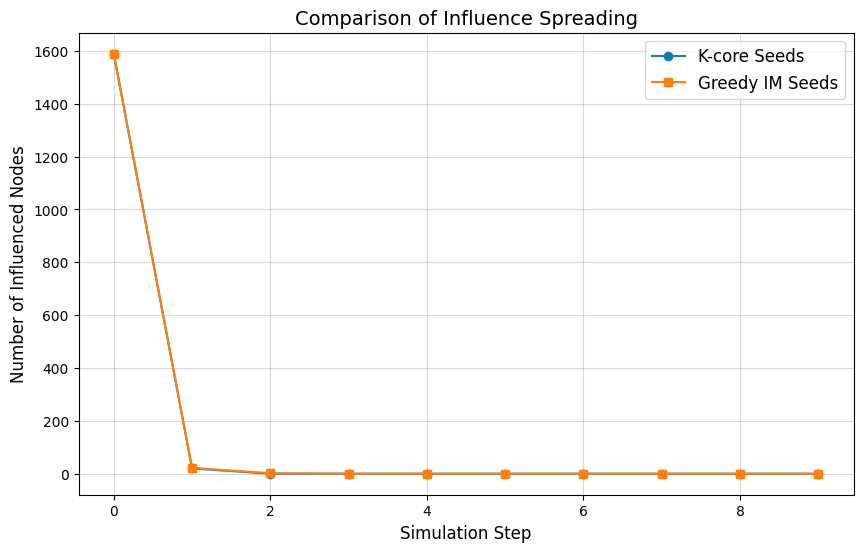

In [28]:
import matplotlib.pyplot as plt

def compare_spreading(graph, k_core_seeds, greedy_seeds, threshold=0.01, steps=10):
    """
    Simulates and compares influence spreading for K-core and Greedy IM seed sets.

    Parameters:
    - graph: A NetworkX graph representing the social network.
    - k_core_seeds: Seed nodes selected based on K-core analysis.
    - greedy_seeds: Seed nodes selected using Greedy IM.
    - threshold: Influence probability for edges (default=0.01).
    - steps: Number of simulation steps (default=10).

    Returns:
    - k_core_results: List of influenced node counts per step for K-core seeds.
    - greedy_results: List of influenced node counts per step for Greedy IM seeds.
    """
    k_core_iterations = simulate_spreading(graph, k_core_seeds, threshold, steps)
    k_core_results = [len(iteration["status"]) for iteration in k_core_iterations]

    greedy_iterations = simulate_spreading(graph, greedy_seeds, threshold, steps)
    greedy_results = [len(iteration["status"]) for iteration in greedy_iterations]

    return k_core_results, greedy_results

def plot_comparison(k_core_results, greedy_results, steps=10):
    """
    Plots the spreading comparison between K-core and Greedy IM seed sets.

    Parameters:
    - k_core_results: List of influenced node counts per step for K-core seeds.
    - greedy_results: List of influenced node counts per step for Greedy IM seeds.
    - steps: Number of simulation steps.
    """
    plt.figure(figsize=(10, 6))
    
    plt.plot(range(steps), k_core_results, label="K-core Seeds", marker='o')
    
    plt.plot(range(steps), greedy_results, label="Greedy IM Seeds", marker='s')
    
    # Customize plot
    plt.title("Comparison of Influence Spreading", fontsize=14)
    plt.xlabel("Simulation Step", fontsize=12)
    plt.ylabel("Number of Influenced Nodes", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.show()



filtered_G = filter_graph(graph, threshold=3)
k_core_nodes = [node for node, _ in compute_k_core_and_simulate(filtered_G, top_n=20)[0]]

selected_nodes = list(filtered_G.nodes())
greedy_seeds = greedy_algorithm(filtered_G, selected_nodes, size=20, sim=simulate_influence_spread)

k_core_results, greedy_results = compare_spreading(graph, k_core_nodes, greedy_seeds)

plot_comparison(k_core_results, greedy_results)
